# Data Exploration

In [1]:
# ============================================
# 1. Setup
# ============================================
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier

In [2]:
# ============================================
# 2. Load Partitioned Parquet Using Dask
# ============================================

PARQUET_DIR = "../src/out_data_pipeline/parquet_out"   

df_dask = dd.read_parquet(PARQUET_DIR)
df_dask

,age,educational-num,gender,capital-gain,capital-loss,hours-per-week,native-country,income,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
npartitions=20,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [3]:
# Convert to Pandas for modeling (baseline)
# If dataset is huge, sample or train using incremental learners instead.
df = df_dask.compute()
df.head()

,age,educational-num,gender,capital-gain,capital-loss,hours-per-week,native-country,income,workclass_Federal-gov,workclass_Local-gov,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,0.208974,7.0,1,0.000000,0.0,0.402758,223445,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,0.340638,9.0,1,0.000000,0.0,0.530232,223445,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.260432,12.0,1,0.000000,0.0,0.436077,223445,1,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0.424785,10.0,1,0.775496,0.0,0.376989,223445,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.123644,10.0,0,0.000000,0.0,0.244071,223445,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [4]:
df.describe(include="all")

,age,educational-num,gender,capital-gain,capital-loss,hours-per-week,native-country,income,workclass_Federal-gov,workclass_Local-gov,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
count,244210.000000,244210.000000,244210.000000,244210.000000,244210.000000,244210.000000,244210.000000,244210.000000,244210.000000,244210.000000,...,244210.000000,244210.000000,244210.000000,244210.000000,244210.000000,244210.000000,244210.000000,244210.000000,244210.000000,244210.000000
mean,0.348024,10.078089,0.668482,0.063040,0.041860,0.388848,204580.547275,0.239282,0.029319,0.064207,...,0.257627,0.030834,0.155215,0.104930,0.047725,0.009623,0.031100,0.095922,0.008313,0.855043
std,0.149176,2.570952,0.470760,0.211602,0.189186,0.127601,61884.135005,0.426646,0.168700,0.245122,...,0.437328,0.172868,0.362110,0.306464,0.213185,0.097623,0.173589,0.294484,0.090793,0.352058
min,0.016820,1.000000,0.000000,0.000000,0.000000,-0.038037,5.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.230873,9.000000,0.000000,0.000000,0.000000,0.339457,223445.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.332113,10.000000,1.000000,0.000000,0.000000,0.388985,223445.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.446907,12.000000,1.000000,0.000000,0.000000,0.444899,223445.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,0.972061,16.000000,1.000000,1.000241,1.003856,0.996137,223445.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


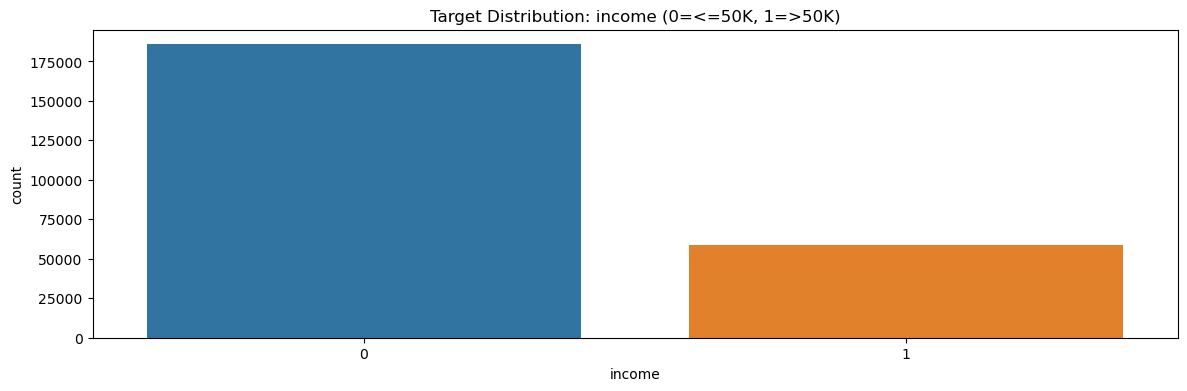

In [5]:
plt.figure(figsize=(14,4))
sns.countplot(x=df["income"])
plt.title("Target Distribution: income (0=<=50K, 1=>50K)")
plt.show()

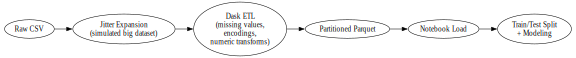

In [6]:
from graphviz import Digraph

flow = Digraph("DataProcessingFlow", format="png")
flow.attr(rankdir="LR", size="8,5")

flow.node("A", "Raw CSV")
flow.node("B", "Jitter Expansion\n(simulated big dataset)")
flow.node("C", "Dask ETL\n(missing values,\nencodings,\nnumeric transforms)")
flow.node("D", "Partitioned Parquet")
flow.node("E", "Notebook Load")
flow.node("F", "Train/Test Split\n+ Modeling")

flow.edges(["AB", "BC", "CD", "DE", "EF"])

flow

In [7]:
target = "income"
X = df.drop(columns=[target])
y = df[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numeric columns (optional but helps LogReg)
numeric_cols = ["age", "capital-gain", "capital-loss", "hours-per-week"]

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

## Baseline Models

In [8]:
log_reg = LogisticRegression(max_iter=200)
log_reg.fit(X_train, y_train)

pred_lr = log_reg.predict(X_test)
proba_lr = log_reg.predict_proba(X_test)[:, 1]

acc_lr = accuracy_score(y_test, pred_lr)
auc_lr = roc_auc_score(y_test, proba_lr)

acc_lr, auc_lr

(0.7607182343065395, 0.6970576927596412)

In [9]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)
proba_rf = rf.predict_proba(X_test)[:, 1]

acc_rf = accuracy_score(y_test, pred_rf)
auc_rf = roc_auc_score(y_test, proba_rf)

acc_rf, auc_rf

(0.9773350804635355, 0.9956133077575149)

In [10]:
comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [acc_lr, acc_rf],
    "ROC-AUC": [auc_lr, auc_rf]
})
comparison

,Model,Accuracy,ROC-AUC
0,Logistic Regression,0.760718,0.697058
1,Random Forest,0.977335,0.995613


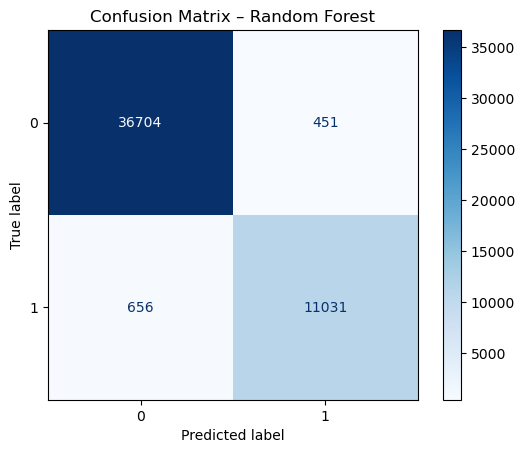

In [11]:
cm = confusion_matrix(y_test, pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Random Forest")
plt.show()

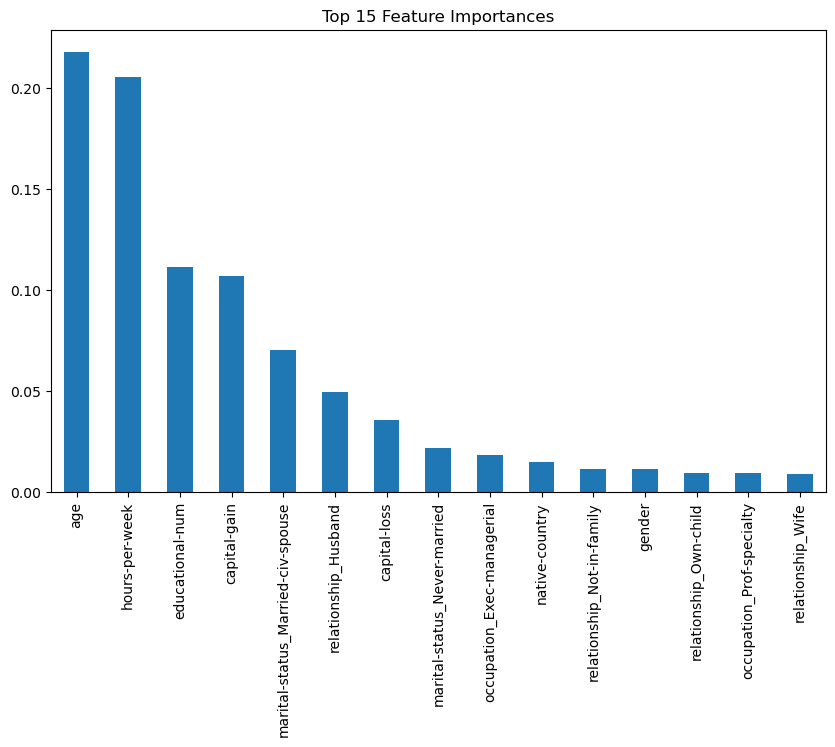

In [12]:
importances = pd.Series(
    rf.feature_importances_, index=X_train.columns
).sort_values(ascending=False)

plt.figure(figsize=(10,6))
importances.head(15).plot(kind="bar")
plt.title("Top 15 Feature Importances")
plt.show()